In [1]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras import regularizers

/home/krati/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load the Data

In [2]:
import os
import numpy as np
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale

In [3]:
original_dataset_dir = "/NASmount/Research Data/Krati/Grasp_point_detection"
os.chdir(original_dataset_dir)
os.getcwd()

'/NASmount/Research Data/Krati/Grasp_point_detection'

In [4]:
train_dir = os.path.join(original_dataset_dir, "Real_data_grasp_point/Sleeveless_Real_Regression/train")

test_dir = os.path.join(original_dataset_dir, "Real_data_grasp_point/Sleeveless_Real_Regression/test")

In [5]:
train_img = []
for img in sorted(glob.glob(train_dir+"/*Sleeveless_*.png")):
    n = cv2.imread(img, 0)
    #n = scale( n, axis=0, with_mean=True, with_std=True, copy=True )
    #n.flatten()
    n = img_to_array(n)
    train_img.append(n)
pa = train_dir+"/*.png"
train_names = [os.path.basename(x) for x in glob.glob(pa)]
train_names = sorted(train_names)

In [6]:
train_names[:15]

['1_Sleeveless_0_1.png',
 '1_Sleeveless_0_10.png',
 '1_Sleeveless_0_11.png',
 '1_Sleeveless_0_12.png',
 '1_Sleeveless_0_13.png',
 '1_Sleeveless_0_14.png',
 '1_Sleeveless_0_15.png',
 '1_Sleeveless_0_16.png',
 '1_Sleeveless_0_17.png',
 '1_Sleeveless_0_18.png',
 '1_Sleeveless_0_19.png',
 '1_Sleeveless_0_2.png',
 '1_Sleeveless_0_20.png',
 '1_Sleeveless_0_21.png',
 '1_Sleeveless_0_22.png']

In [7]:
test_img = []
for img in sorted(glob.glob(test_dir+"/*_depth.png")):
    n = cv2.imread(img, 0)
    #n = scale( n, axis=0, with_mean=True, with_std=True, copy=True )
    #n.flatten()
    n = img_to_array(n)
    test_img.append(n)
pa = test_dir+"/*.png"
test_names = [os.path.basename(x) for x in glob.glob(pa)]
test_names = sorted(test_names)

In [8]:
test_names[:15]

['0000_depth.png',
 '0001_depth.png',
 '0002_depth.png',
 '0003_depth.png',
 '0004_depth.png',
 '0005_depth.png',
 '0006_depth.png',
 '0007_depth.png',
 '0008_depth.png',
 '0009_depth.png',
 '0010_depth.png',
 '0011_depth.png',
 '0012_depth.png',
 '0013_depth.png',
 '0014_depth.png']

In [9]:
for i in range(len(test_img)):
    test_img[i] = test_img[i].reshape((250,200))
test_img[1].shape

(250, 200)

In [10]:
for i in range(len(train_img)):
    train_img[i] = train_img[i].reshape((250,200))
train_img[1].shape

(250, 200)

In [11]:
train = pd.DataFrame.from_records(train_img)
train = train.values
print(type(train))
print(train.shape)

<class 'numpy.ndarray'>
(36720, 250)


In [12]:
test = pd.DataFrame.from_records(test_img)
test = test.values
print(type(test))
print(test.shape)

<class 'numpy.ndarray'>
(7141, 250)


In [13]:
test = test.flatten()
train = train.flatten()
print(test.shape, train.shape)

(1785250,) (9180000,)


### Get train labels

In [19]:
train_labels = pd.read_csv("Real_data_grasp_point/Sleeveless_Real_Regression/train_labels.csv", header=None)

In [20]:
print(len(train_img), len(test_img))

36720 7141


In [21]:
print(train_labels.shape)

(36720, 6)


In [22]:
## get label values
train_values = train_labels.values

In [23]:
print(type(train_values))

<class 'numpy.ndarray'>


In [24]:
def read_and_normalize_train_data(train_data, train_target):
    train_data = np.array(train_data, dtype=np.float32)
    train_target = np.array(train_target, dtype=np.float32)
    m = train_data.mean()
    s = train_data.std()

    print ('Train mean, sd:', m, s )
    train_data -= m
    train_data /= s
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target

In [25]:
def make_data(labels, img_list):
    X_train = []
    y_train = []
    print('Read images')
    for index, row in labels.iterrows():
        img = img_list[index].astype(np.float32)
        X_train.append(img)
        y_train.append([row.values])
    return X_train, y_train

In [26]:
X_train, y_train = make_data(train_labels, train_img)

Read images


In [27]:
X_train, y_train = read_and_normalize_train_data(X_train, y_train)

Train mean, sd: 33.182964 79.715096
Train shape: (36720, 250, 200)
36720 train samples


# CNN Models

In [28]:
def build_model2():
    model = models.Sequential()
    model.add(layers.Dense(512, activation = 'relu', input_shape=(None,200)))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(6))
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

In [29]:
model = build_model2()
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, None, 512)         102912    
_________________________________________________________________
dense_2 (Dense)              (None, None, 128)         65664     
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
dense_4 (Dense)              (None, None, 64)          8256      
_________________________________________________________________
dense_5 (Dense)              (None, None, 64)          4160      
_________________________________________________________________
dense_6 (Dense)              (None, None, 6)           390       
Total params: 197,894
Trainable params: 197,894
Non-trainable params:

In [30]:
history3 = model.fit(X_train, y_train,
          batch_size=16, epochs=30)

Epoch 1/30
36720/36720 [==============================] - 87s 2ms/step - loss: 0.0935 - mean_absolute_error: 0.2077
Epoch 2/30
36720/36720 [==============================] - 84s 2ms/step - loss: 0.0908 - mean_absolute_error: 0.2024
Epoch 3/30
36720/36720 [==============================] - 83s 2ms/step - loss: 0.0906 - mean_absolute_error: 0.2018
Epoch 4/30
36720/36720 [==============================] - 84s 2ms/step - loss: 0.0904 - mean_absolute_error: 0.2013
Epoch 5/30
36720/36720 [==============================] - 84s 2ms/step - loss: 0.0902 - mean_absolute_error: 0.2010
Epoch 6/30
36720/36720 [==============================] - 84s 2ms/step - loss: 0.0902 - mean_absolute_error: 0.2010
Epoch 7/30
36720/36720 [==============================] - 85s 2ms/step - loss: 0.0902 - mean_absolute_error: 0.2011
Epoch 8/30
36720/36720 [==============================] - 85s 2ms/step - loss: 0.0902 - mean_absolute_error: 0.2010
Epoch 9/30
36720/36720 [==============================] - 86s 2ms/step -

In [31]:
model.save("S_orig_512_128_128_64_64_5layers.h5")

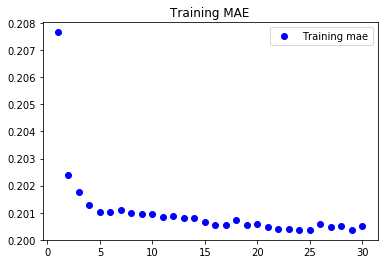

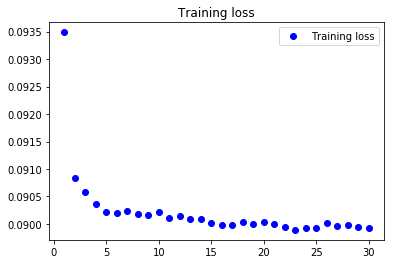

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
mae = history3.history['mean_absolute_error']
#val_mae = history3.history['val_mean_absolute_error']
loss = history3.history['loss']
#val_loss = history3.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training mae')
#plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training MAE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [33]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, activation = 'relu', input_shape=(None,200)))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(6))
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

In [34]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, None, 32)          6432      
_________________________________________________________________
dense_8 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dense_9 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dense_10 (Dense)             (None, None, 6)           198       
Total params: 8,742
Trainable params: 8,742
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train,
          batch_size=16, epochs=30)

Epoch 1/30
36720/36720 [==============================] - 23s 632us/step - loss: 0.0943 - mean_absolute_error: 0.2084
Epoch 2/30
36720/36720 [==============================] - 23s 631us/step - loss: 0.0914 - mean_absolute_error: 0.2036
Epoch 3/30
36720/36720 [==============================] - 23s 625us/step - loss: 0.0910 - mean_absolute_error: 0.2027
Epoch 4/30
36720/36720 [==============================] - 23s 621us/step - loss: 0.0907 - mean_absolute_error: 0.2021
Epoch 5/30
36720/36720 [==============================] - 23s 618us/step - loss: 0.0905 - mean_absolute_error: 0.2018
Epoch 6/30
36720/36720 [==============================] - 23s 639us/step - loss: 0.0905 - mean_absolute_error: 0.2016
Epoch 7/30
36720/36720 [==============================] - 23s 618us/step - loss: 0.0904 - mean_absolute_error: 0.2013
Epoch 8/30
36720/36720 [==============================] - 23s 631us/step - loss: 0.0903 - mean_absolute_error: 0.2012
Epoch 9/30
36720/36720 [==============================] 

In [36]:
model.save("S_orig_32_3layers.h5")

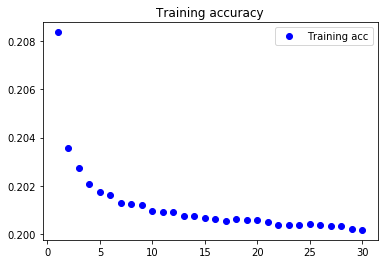

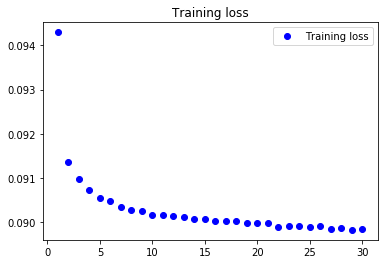

In [37]:
mae = history.history['mean_absolute_error']
#val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training acc')
#plt.plot(epochs, val_mae, 'b', label='Validation acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [38]:
def build_model4():
    model = models.Sequential()
    model.add(layers.Dense(32, activation = 'relu', input_shape=(None,200)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation = 'relu'))
    
    model.add(layers.Dense(6))
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

In [39]:
model = build_model4()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, None, 32)          6432      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_12 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_13 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_14 (Dense)             (None, None, 32)          1056      
__________

In [40]:
history5 = model.fit(X_train, y_train,
          batch_size=128, epochs=30)

Epoch 1/30
36720/36720 [==============================] - 20s 544us/step - loss: 0.1213 - mean_absolute_error: 0.2475
Epoch 2/30
36720/36720 [==============================] - 19s 513us/step - loss: 0.0923 - mean_absolute_error: 0.2056
Epoch 3/30
36720/36720 [==============================] - 19s 508us/step - loss: 0.0914 - mean_absolute_error: 0.2035
Epoch 4/30
36720/36720 [==============================] - 19s 506us/step - loss: 0.0911 - mean_absolute_error: 0.2029
Epoch 5/30
36720/36720 [==============================] - 19s 529us/step - loss: 0.0910 - mean_absolute_error: 0.2025
Epoch 6/30
36720/36720 [==============================] - 20s 552us/step - loss: 0.0909 - mean_absolute_error: 0.2022
Epoch 7/30
36720/36720 [==============================] - 19s 506us/step - loss: 0.0908 - mean_absolute_error: 0.2021
Epoch 8/30
36720/36720 [==============================] - 19s 513us/step - loss: 0.0907 - mean_absolute_error: 0.2019
Epoch 9/30
36720/36720 [==============================] 

In [41]:
model.save("S_orig_32_4layers_with_dropout.h5")

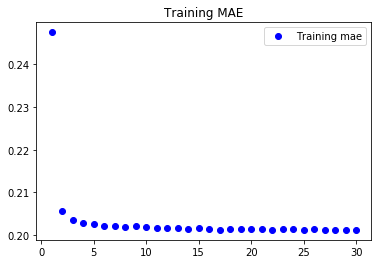

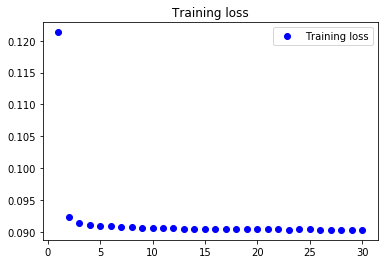

In [42]:
mae = history5.history['mean_absolute_error']
#val_mae = history5.history['val_mean_absolute_error']
loss = history5.history['loss']
#val_loss = history5.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training mae')
#plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training MAE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [43]:
def build_model5():
    model = models.Sequential()
    model.add(layers.Dense(32, activation = 'relu', input_shape=(None,200)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(6))
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

In [44]:
model = build_model5()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, None, 32)          6432      
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_17 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_18 (Dense)             (None, None, 6)           198       
Total params: 7,686
Trainable params: 7,686
Non-trainable params: 0
_________________________________________________________________


In [45]:
history6 = model.fit(X_train, y_train,
          batch_size=128, epochs=30)

Epoch 1/30
36720/36720 [==============================] - 16s 440us/step - loss: 0.1357 - mean_absolute_error: 0.2598
Epoch 2/30
36720/36720 [==============================] - 16s 439us/step - loss: 0.0947 - mean_absolute_error: 0.2111
Epoch 3/30
36720/36720 [==============================] - 16s 425us/step - loss: 0.0930 - mean_absolute_error: 0.2071
Epoch 4/30
36720/36720 [==============================] - 15s 422us/step - loss: 0.0922 - mean_absolute_error: 0.2051
Epoch 5/30
36720/36720 [==============================] - 15s 404us/step - loss: 0.0918 - mean_absolute_error: 0.2039
Epoch 6/30
36720/36720 [==============================] - 15s 414us/step - loss: 0.0915 - mean_absolute_error: 0.2033
Epoch 7/30
36720/36720 [==============================] - 14s 393us/step - loss: 0.0913 - mean_absolute_error: 0.2028
Epoch 8/30
36720/36720 [==============================] - 14s 392us/step - loss: 0.0911 - mean_absolute_error: 0.2026
Epoch 9/30
36720/36720 [==============================] 

In [46]:
model.save("S_orig_32_2layers_with_dropout.h5")

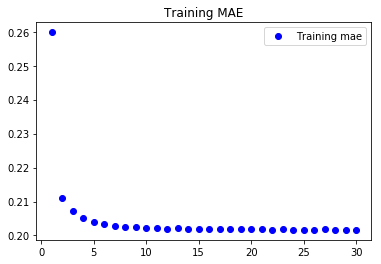

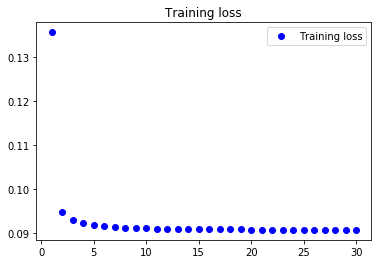

In [47]:
mae = history6.history['mean_absolute_error']
#val_mae = history6.history['val_mean_absolute_error']
loss = history6.history['loss']
#val_loss = history6.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training mae')
#plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training MAE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()